In [2]:
from keras.models import Sequential, load_model
import pandas as pd
import numpy as np
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import random
import datetime

from Indicator import Indicator

def check_trend(df):
    df.loc[(df['Close'] > df['MA']) &
    ((df['Close'] > df['Close'].shift(1)) | (df['MA'] > df['MA'].shift(1))) &
    ((df['Close'] > df['Close'].shift(2)) | (df['MA'] > df['MA'].shift(2))) &
    ((df['Close'] > df['Close'].shift(3)) | (df['MA'] > df['MA'].shift(3))) &
    ((df['Close'] > df['Close'].shift(4)) | (df['MA'] > df['MA'].shift(4))) &
    ((df['Close'] > df['Close'].shift(5)) | (df['MA'] > df['MA'].shift(5))) , 'Trend'] = 'Up'

    df.loc[(df['Close'] < df['MA']) &
    ((df['Close'] < df['Close'].shift(1)) | (df['MA'] < df['MA'].shift(1))) &
    ((df['Close'] < df['Close'].shift(2)) | (df['MA'] < df['MA'].shift(2))) &
    ((df['Close'] < df['Close'].shift(3)) | (df['MA'] < df['MA'].shift(3))) &
    ((df['Close'] < df['Close'].shift(4)) | (df['MA'] < df['MA'].shift(4))) &
    ((df['Close'] < df['Close'].shift(5)) | (df['MA'] < df['MA'].shift(5))) , 'Trend'] = 'Down'
    
    df.loc[df['Trend'].isnull(), 'Ntrend'] = df['Trend'].shift(1)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull(),'Ntrend'] = df['Trend'].shift(2)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull() & df['Trend'].shift(2).isnull(),'Ntrend'] = df['Trend'].shift(3)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull() & df['Trend'].shift(2).isnull() & 
    df['Trend'].shift(3).isnull(),'Ntrend'] = df['Trend'].shift(4)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull() & df['Trend'].shift(2).isnull() & 
    df['Trend'].shift(3).isnull() & df['Trend'].shift(4).isnull(),'Ntrend'] = df['Trend'].shift(5)
    df.loc[df['Trend'].isnull() & df['Trend'].shift(1).isnull() & df['Trend'].shift(2).isnull() & 
    df['Trend'].shift(3).isnull() & df['Trend'].shift(4).isnull() & df['Trend'].shift(5).isnull(),'Ntrend'] = df['Trend'].shift(6)
    
    df['S1'] = df['Close'].shift(-1)
    df['S2'] = df['Close'].shift(-2)
    df.loc[df['S1'].isnull(),'S1'] = 0
    df.loc[df['S2'].isnull(),'S2'] = 0

   
    #Trading Signal (0,1)
    df.loc[(df['Trend'] == 'Up') | (df['Ntrend'] == 'Up'), 'Trading Signal'] = ((abs(df['Close'] - df[['Close','S1','S2']].min(axis = 1)) / 
    abs(df[['Close','S1','S2']].max(axis = 1) - df[['Close','S1','S2']].min(axis = 1)))*0.5) + 0.5
    df.loc[(df['Trend'] == 'Down') | (df['Ntrend'] == 'Down'), 'Trading Signal'] = ((abs(df['Close'] - df[['Close','S1','S2']].min(axis = 1)) / 
    abs(df[['Close','S1','S2']].max(axis = 1) - df[['Close','S1','S2']].min(axis = 1)))*0.5)
   
    df.loc[df['Trend'].isnull(),'Trend'] =df['Ntrend']
    
    df = df.drop(['Ntrend','S1','S2'],axis=1)
        
    return df

# def fillindicator(df):
#     indicator = Indicator()
#     train_set = indicator.MA(df,15)
#     train_set = indicator.MACD(df)
#     train_set = indicator.STOCHASTIC(df)
#     train_set = indicator.RSI(df)
#     train_set = indicator.WILLIAMSR(df)
#     train_set = indicator.DMI(df)
#     train_set = indicator.AROON(df)
#     train_set = indicator.ATR(df)
#     train_set = indicator.CCI(df)
#     train_set = indicator.OBV(df)
#     return train_set

def norm(df,col_name):# this will get columnname + _n
    #Normalize data each colunm in to range -1 to 1
    df[col_name+'_n'] = (df[col_name]-df[col_name].min())/(df[col_name].max()-df[col_name].min())
    return df

def signal_to_num(df):
    df.loc[df['Trend']=='Down','Trend'] = 0
    df.loc[df['Trend']=='Up','Trend'] = 1
    return df

def fillindicator(df):
    indicator = Indicator()
    train_set = indicator.MACD(df,12,26,9,1)#MACD 1
    train_set = indicator.MACD(df,40,60,34,2)#MACD 2
    train_set = indicator.DMI(df,14)
    train_set = indicator.STOCHRSI(df)
    train_set = indicator.AO(df)
    train_set = indicator.WILLIANSR(df)
    train_set = indicator.RSI(df)
    train_set = indicator.MA(df,26)
    train_set['MA-26'] = train_set['MA']
    train_set = indicator.MA(df,15)
    train_set = indicator.check_trend(df)
    return train_set

def shiftdata(df,col_name,sft):
    for i in range(sft):
        i+=1
        shiftname = col_name+'-'+str(i)
        df[shiftname] = df[col_name].shift(i)

    return df

def add_shift_day(data,day):
    r_list = []
    for i in range(day,len(data)):#Number mean day to shift
        r_list.append(data[i-day : i])
    return np.array(r_list)

In [3]:
start = datetime.datetime(2006,10,1)#26 day before start year for make indicator
end = datetime.datetime(2017,1,1)

money = 100000
# stocklist = ['AES','EBAY','VRTX','GOOGL','IP','CSCO','UAL','NVR','TPR','BA']
# stocklist = ['AMD','LRCX','KLAC','TGT','CMG','QRVO','CPRT','XRX','AMAT','LDOS'] #top10
# stocklist = ['FOSL','ABMD','M','MAC','TRIP','OXY','SWN','OI','GPS'] #bottom 10
stocklist = ['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DD','XOM','GE','GS','HD','IBM','INTC','JNJ','JPM','MCD',
                 'MRK','MSFT','NKE','PFE','PG','TRV','UNH','VZ','WMT']


In [7]:
model = load_model('Model4_5_300.h5')

In [8]:
#Project model
PJmodel = []

for stock in stocklist:
    try:
        df = web.DataReader(stock,'yahoo',start,end)
        df = fillindicator(df)
    #     df['AO-signal'] = np.where(df['AO'] > df['AO'].shift(1),1,0)
        df.loc[df['Trend'] == 'Down', 'Trend'] = 0.1
        df.loc[df['Trend'] == 'Up', 'Trend'] = 0.9 

        #Delta
        df['MACD-SL-1'] = df['MACD-1'] - df['SIGNAL LINE1']
        df['MACD-SL-2'] = df['MACD-2'] - df['SIGNAL LINE2']
        df['DMI'] = df['plusDI'] - df['minusDI']
        df['STOCHRSI'] = df['%K'] - df['%D']
        df['MA-trend'] = df['MA-26'] - df['Close']

        #MACD
        df = norm(df,'MACD-SL-1')
        df = norm(df,'MACD-SL-2')
        df = norm(df,'MACD-1')
        df = norm(df,'MACD-2')
        df = norm(df,'SIGNAL LINE1')
        df = norm(df,'SIGNAL LINE2')

        #DMI
        df = norm(df,'plusDI')
        df = norm(df,'minusDI')
        df = norm(df,'DMI')

        #StochasticRSI
        df = norm(df,'%K')
        df = norm(df,'%D')
        df = norm(df,'STOCHRSI')

        #Other
        df = norm(df,'Close')
        df = norm(df,'%R')
        df = norm(df,'RSI')
        df = norm(df,'AO')
        df = norm(df,'MA-trend')

        df = df[63:]
        p_test = df
        x_test = p_test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','AO_n','RSI_n','MA-trend']].values
        x_test = add_shift_day(x_test,14)
        y_pred = model.predict(x_test)
        y_pred = np.argmax(y_pred,axis = -1)
        p_test = p_test.iloc[14:]

        p_test['pred'] = y_pred
        p_test['pred_b'] = np.where(p_test['pred'] == 0,p_test['Close'],np.nan)
        p_test['pred_s'] = np.where(p_test['pred'] == 1,p_test['Close'],np.nan)
        b = []
        s = []
        flag = 'sell'
        for i,r in p_test.iterrows():
            if (flag=='sell') & (r['pred']==0):
                b.append(r['Close'])
                flag = 'buy'
            elif (flag=='buy') & (r['pred']==1):
                s.append(r['Close'])
                flag = 'sell'
        if len(b)>len(s):
            del b[-1]
        modelbuy = len(b)
        modelsell = len(s)
        pfmodel = []
        profitmodel = []
        for i in range(len(b)):
            pfmodel.append(((s[i]-b[i])/(b[i]))*money)
            profitmodel.append(((s[i]-b[i])/(b[i])))
        if modelbuy >0:
            PJmodel.append([stock,(sum(profitmodel)/modelbuy)*100,modelbuy,sum(pfmodel)])    
        else:
            PJmodel.append([stock,0,0,0])    
    except:
        print(stock)

C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [11]:
sumprofit = []
print('start',start,'end',end)
print('                  Stock,         Profit %,     nbuy,nsell,Profit')
for i in range(len(PJmodel)):
    print('Project Model   ',PJmodel[i])
    sumprofit.append(PJmodel[i][3])
    print('--------------------------------------------------------------------------------')
print('Total Profit = ',sum(sumprofit))

start 2006-10-01 00:00:00 end 2017-01-01 00:00:00
                  Stock,         Profit %,     nbuy,nsell,Profit
Project Model    ['MMM', 0.9950148450281766, 5, 4975.074225140883]
--------------------------------------------------------------------------------
Project Model    ['AXP', -1.1368713404570185, 4, -4547.485361828078]
--------------------------------------------------------------------------------
Project Model    ['AAPL', 2.5314423907359282, 1, 2531.4423907359283]
--------------------------------------------------------------------------------
Project Model    ['BA', -0.04944101456962561, 2, -98.88202913925124]
--------------------------------------------------------------------------------
Project Model    ['CAT', -2.064187641595537, 4, -8256.750566382147]
--------------------------------------------------------------------------------
Project Model    ['CVX', 6.092848610880465, 4, 24371.394443521862]
-----------------------------------------------------------------------

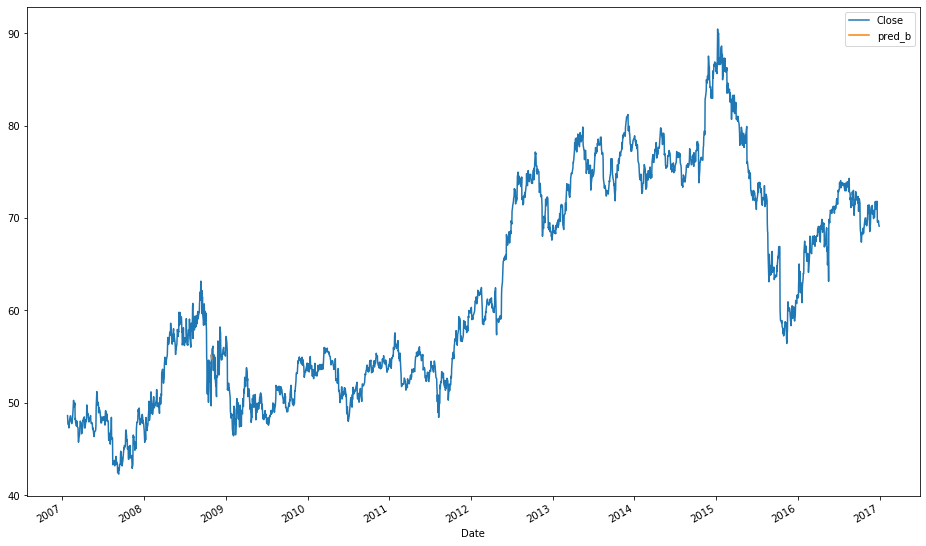

In [12]:
p_test[['Close','pred_b']].plot(figsize = (16,10))

133445.13251935263 model4 100 epoch acc 0.8
84443.47571120781 model4 150 epoch acc0.85
95299.4219234237 model4 200epoch acc 0.9091
-30400.565910062807 model 300epoch acc 0.92
56439.6605518079 model4 350epoch acc 0.938